In [1]:
# Load & query database
import sqlite3
conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# do t-tests
from scipy import stats
import sys  
sys.path.insert(0, '../dsc-website-ab-testing-lab-online-ds-sp-000/')
import flatiron_stats as fstats

In [21]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats

In [ ]:
#calculate effect sizes (diff in price w.r.t. sample size ? ) and find p values?
from statsmodels.stats.power import TTestIndPower, TTestPower

In [3]:
query = """SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;"""

In [4]:
query = """SELECT * FROM 'OrderDetail';"""

In [5]:
cur.execute(query)
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [6]:
discount_df = df[df.Discount != 0]
fullprice_df = df[df.Discount == 0]

In [7]:
discount_df.Discount.value_counts()

0.05    185
0.10    173
0.20    161
0.15    157
0.25    154
0.03      3
0.02      2
0.04      1
0.06      1
0.01      1
Name: Discount, dtype: int64

In [7]:
# Basic EDA, discount amount & sales
print("Mean quantity in non discount orders {} vs. discounted: {}".format(round(fullprice_df.Quantity.mean(), 1)
                                                                         ,round(discount_df.Quantity.mean(),1)))
print("SD non discount {} vs. discounted {}".format(round(np.std(fullprice_df.Quantity),1 ),
                                                    round(np.std(discount_df.Quantity),1 ) ))

Mean quantity in non discount orders 21.7 vs. discounted: 27.1
SD non discount 17.5 vs. discounted 20.8


In [17]:
discount_df.Quantity.sum(), fullprice_df.Quantity.sum()

(22718, 28599)

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


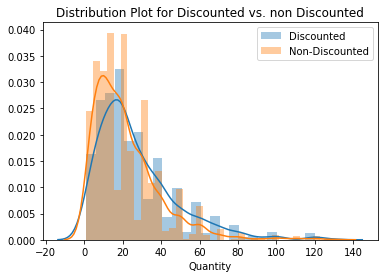

In [12]:
sns.distplot(discount_df.Quantity, label='Discounted')
sns.distplot(fullprice_df.Quantity, label='Non-Discounted').set_title("Distribution Plot for Discounted vs. non Discounted")
plt.legend()
plt.show();

In [26]:
#KS test to see if the data comes from the same distributions
print(stats.kstest(discount_df.Quantity, 'norm'))
print(stats.kstest(fullprice_df.Quantity, 'norm'))
print(stats.ks_2samp(fullprice_df.Quantity,discount_df.Quantity))

KstestResult(statistic=0.9724765983620833, pvalue=0.0)
KstestResult(statistic=0.9673789492970751, pvalue=0.0)
Ks_2sampResult(statistic=0.12135050550629461, pvalue=4.763897379538179e-07)


In [ ]:
# do t-test, and then ANOVA for each discount group type

In [18]:
stats.ttest_ind(discount_df.Quantity, discount_df.Quantity, equal_var=False) #when equal_var=False, welch's t test is used.

Ttest_indResult(statistic=0.0, pvalue=1.0)

In [12]:
fstats.welch_t(discount_df.Quantity, discount_df.Quantity)

0.0

In [14]:
fstats.p_value_welch_ttest(discount_df.Quantity, discount_df.Quantity)

0.5

In [20]:
# Your code here
formula = 'Quantity ~ Discount'
lm = ols(formula,df).fit() 
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                 sum_sq      df          F        PR(>F)
Discount   12884.989179     1.0  36.191587  2.095888e-09
Residual  766514.647015  2153.0        NaN           NaN


In [27]:
# Your code here
formula = 'Quantity ~ C(Discount)'
lm = ols(formula,df).fit() 
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                    sum_sq      df         F        PR(>F)
C(Discount)   21258.403604    10.0  6.011811  4.704231e-09
Residual     758141.232591  2144.0       NaN           NaN


#### Other hypothesis
Does price affect & discount have an effect on total widgets purchased? 
Are some items just things you buy lots of (like paper clips) and discount doesn't really matter vs. other things that are costly and you only need a few?


In [29]:
formula = 'Quantity ~ C(Discount) + UnitPrice'
lm = ols(formula,df).fit() 
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                    sum_sq      df         F        PR(>F)
C(Discount)   21255.528525    10.0  6.008507  4.771280e-09
UnitPrice        39.418992     1.0  0.111429  7.385552e-01
Residual     758101.813599  2143.0       NaN           NaN


In [ ]:
df = pd.get_dummies(df, columns=['Discount'], prefix=["discount"])
X = df.drop(['Id', 'OrderId', 'ProductId'], axis=1)
new_columns = []
for x in X.columns:
    x = x.replace(".", '')
    new_columns.append(x)
X.columns = new_columns
X.head()


In [ ]:
outcome = 'Quantity'
predictors = X.columns
f = '+'.join(predictors)
formula = outcome + '~' + f
stats_model = ols(formula=formula, data=X).fit()

In [ ]:
stats_model.summary()

In [ ]:
#Visualize interactions
#https://blog.insightdatascience.com/data-visualization-in-python-advanced-functionality-in-seaborn-20d217f1a9a6
sns.factorplot(data=df, x="model_year", y="mpg", col="origin")